In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [ ]:
# read data and merge the train and test with features

coded_id = pd.read_csv("users/coded_ids.csv")
features = pd.read_csv("users_features/features.csv")
users = pd.merge(features, coded_id, on='user_id', how='left')

train = pd.read_csv("users/coded_ids_labels_train.csv")
test = pd.read_csv("users/coded_ids_labels_test.csv")
train = pd.merge(users, train, on='coded_id', how='right')
test = pd.merge(users, test, on='coded_id', how='right')

In [ ]:
train.shape

(686, 125)

In [ ]:
test.shape

(81, 124)

In [ ]:
#cleaning train dataset

#remove columns with na values
nacolumns = train.columns[train.isna().any()].tolist()
train.drop(columns = nacolumns,inplace=True)
train.dropna(axis=0,inplace=True)

#remove unwanted category columns like time and IDs
unwanted = ["default_profile","default_profile_image","avg_intertweet_times","date_newest_tweet","lang","min_intertweet_times","std_nb_symbols_per_tweet","std_nb_symbols_per_word_in_the_tweet","date_oldest_tweet","max_intertweet_times","max_nb_symbols_per_tweet","max_nb_symbols_per_word_in_the_tweet","std_intertweet_times","user_id","coded_id"]
train.drop(columns=unwanted,inplace=True)

#remove columns like 
allzero_cols = list(train.loc[:,(train==0).all()].columns)
train.drop(columns=allzero_cols,inplace=True)


In [ ]:
#cleaning test dataset

#remove columns with na values
nacolumns = test.columns[test.isna().any()].tolist()
test.drop(columns = nacolumns,inplace=True)
test.dropna(axis=0,inplace=True)

#remove unwanted category columns like time and IDs
unwanted = ["default_profile","default_profile_image","avg_intertweet_times","date_newest_tweet","lang","min_intertweet_times","std_nb_symbols_per_tweet","std_nb_symbols_per_word_in_the_tweet","date_oldest_tweet","max_intertweet_times","max_nb_symbols_per_tweet","max_nb_symbols_per_word_in_the_tweet","std_intertweet_times","user_id","coded_id"]
test.drop(columns=unwanted,inplace=True)

#remove columns like 
allzero_cols = list(test.loc[:,(test==0).all()].columns)
test.drop(columns=allzero_cols,inplace=True)


In [ ]:
#split data into x features and labels
x = train.iloc[:,:124]

#normalizing the numerical features
scale = StandardScaler()
x = scale.fit_transform(x)
test = scale.fit_transform(test)

y = train.label

In [ ]:
x.shape

(686, 124)

In [ ]:
y.value_counts()

0    568
1    118
Name: label, dtype: int64

In [ ]:
#train test (validation) split
x_train, x_test, y_train, y_test = train_test_split(x,y ,stratify=y, test_size=0.15,random_state=1)

In [ ]:
#function for performing grid search

def grid_search(model,params):
  skf = StratifiedKFold(n_splits=10)
  gs = GridSearchCV(model, cv=skf, param_grid=params, return_train_score=True)
  gs.fit(x_train, y_train)
  print("best params = ",gs.best_params_)
  print("best score =",gs.best_score_)

In [ ]:
#naives bayes
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
params = {"var_smoothing":[1,0.1,1e-2]}

grid_search(model,params)

best params =  {'var_smoothing': 0.1}
best score = 0.9176504967855055


In [ ]:
#naives bayes test
model = GaussianNB(var_smoothing=0.1)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9228
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        85
           1       0.63      0.94      0.76        18

    accuracy                           0.89       103
   macro avg       0.81      0.91      0.84       103
weighted avg       0.92      0.89      0.90       103



In [ ]:
#knn

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
params = {"n_neighbors":[i for i in range(1,20)]}

grid_search(model,params)

best params =  {'n_neighbors': 3}
best score = 0.950292226767972


In [ ]:
#knn test

model = KNeighborsClassifier(n_neighbors=3)
model.fit(x_train, y_train)
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 0.9691
              precision    recall  f1-score   support

           0       0.94      0.99      0.97        85
           1       0.93      0.72      0.81        18

    accuracy                           0.94       103
   macro avg       0.94      0.86      0.89       103
weighted avg       0.94      0.94      0.94       103



In [ ]:
#svm

from sklearn.svm import SVC

model = SVC()
params = {"C":[0.1,1,10],
          "kernel":["linear", "poly", "rbf", "sigmoid"]}
grid_search(model,params)

best params =  {'C': 10, 'kernel': 'poly'}
best score = 0.9571011104617183


In [ ]:
#decision tree
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
params = {"criterion":["gini","entropy"],
          "max_depth":range(1,10),
          "min_samples_split":range(2,10),
          "min_samples_leaf":range(1,5)}
grid_search(model,params)

best params =  {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 9}
best score = 0.9588544710695499


In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
grid_search(model,params)

best params =  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}
best score = 0.9622735242548217


In [ ]:
#MLP
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

model = Sequential()
model.add(Dense(50, input_dim=124, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
59/59 [==============================] - 0s 1ms/step - loss: 0.9701 - accuracy: 0.4044
Epoch 2/50
59/59 [==============================] - 0s 1ms/step - loss: 0.2546 - accuracy: 0.9463
Epoch 3/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1541 - accuracy: 0.9499
Epoch 4/50
59/59 [==============================] - 0s 1ms/step - loss: 0.1025 - accuracy: 0.9758
Epoch 5/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0949 - accuracy: 0.9753
Epoch 6/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0803 - accuracy: 0.9774
Epoch 7/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9845
Epoch 8/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0517 - accuracy: 0.9793
Epoch 9/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0562 - accuracy: 0.9857
Epoch 10/50
59/59 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9920
Epoch 11/50
59/59 [

In [ ]:
y_pred_train = model.predict_classes(x_train)
y_pred_test = model.predict_classes(x_test)
print('Model train accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred_test))

Model train accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        85
           1       1.00      1.00      1.00        18

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#MLP
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder

model = Sequential()
model.add(Dense(50, input_dim=124, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x, y, epochs=50, batch_size=10)

Epoch 1/50
69/69 [==============================] - 1s 1ms/step - loss: 0.5201 - accuracy: 0.7616
Epoch 2/50
69/69 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.9548
Epoch 3/50
69/69 [==============================] - 0s 1ms/step - loss: 0.0912 - accuracy: 0.9767
Epoch 4/50
69/69 [==============================] - 0s 1ms/step - loss: 0.0794 - accuracy: 0.9881
Epoch 5/50
69/69 [==============================] - 0s 1ms/step - loss: 0.0660 - accuracy: 0.9857
Epoch 6/50
69/69 [==============================] - 0s 1ms/step - loss: 0.0487 - accuracy: 0.9868
Epoch 7/50
69/69 [==============================] - 0s 1ms/step - loss: 0.0394 - accuracy: 0.9916
Epoch 8/50
69/69 [==============================] - 0s 2ms/step - loss: 0.0389 - accuracy: 0.9912
Epoch 9/50
69/69 [==============================] - 0s 1ms/step - loss: 0.0431 - accuracy: 0.9843
Epoch 10/50
69/69 [==============================] - 0s 1ms/step - loss: 0.0278 - accuracy: 0.9968
Epoch 11/50
69/69 [

In [ ]:
y_pred_dnn = model.predict_classes(test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
pred1 = pd.DataFrame(y_pred_dnn,columns=["dnn_pred"])
pred1.to_csv("predictions_bigdata.csv",index=False)

In [ ]:
pred1.dnn_pred.value_counts()

0    68
1    13
Name: dnn_pred, dtype: int64

In [ ]:
#misc 

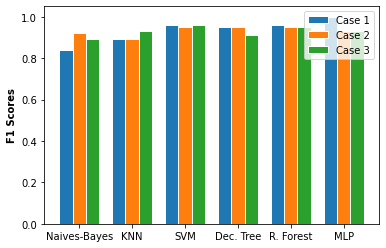

In [ ]:
# set width of bar
barWidth = 0.25
 


# set height of bar
bars1 = [0.84,0.89,0.96,0.95,0.96,1.00]
bars2 = [0.92,0.89,0.95,0.95,0.95,0.93]
bars3 = [0.89,0.93,0.96,0.91,0.95,0.93]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='Case 1')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='Case 2')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='Case 3')
 
# Add xticks on the middle of the group bars
plt.ylabel('F1 Scores', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Naives-Bayes', 'KNN', 'SVM', 'Dec. Tree', 'R. Forest', "MLP"])
 
# Create legend & Show graphic
plt.legend()
plt.savefig("f1score", bbox_inches='tight',dpi = 200)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 686 samples in 0.012s...
[t-SNE] Computed neighbors for 686 samples in 0.149s...
[t-SNE] Computed conditional probabilities for sample 686 / 686
[t-SNE] Mean sigma: 3.220567
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.282059
[t-SNE] KL divergence after 300 iterations: 1.038908


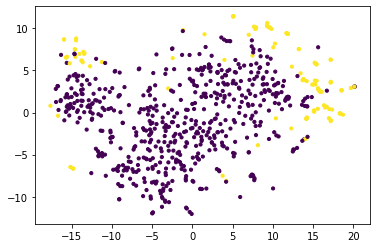

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x)

a = tsne_results[:,0]
b = tsne_results[:,1]



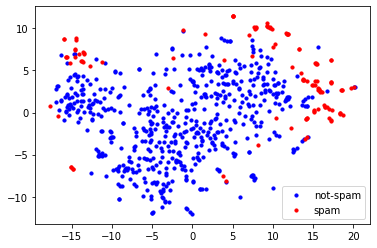

In [ ]:
plt.scatter(aa.a,aa.b,c="b",s=10,label="not-spam")
plt.scatter(bb.a,bb.b,c="r",s=10,label="spam")
plt.legend()
plt.savefig("tsne", bbox_inches='tight',dpi = 200)